In [46]:
import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from sim import cryosim as cryo

### New Environment that has continuous states and actions :)

In [47]:
class DetectorEnv(gym.Env):
    """
    Detector calibration environment using cryo.Cryosim.
    - Action: adapting DAC
    - Observation: [DAC, pulse_height] 
    - Reward: pulse_height
    - Episode length: fixed via max_steps
    """
    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        *,
        # ---- control bounds / horizon ----
        dac_min: float = 0.0,
        dac_max: float = 1e-5,
        max_steps: int = 5, # very low for testing purposes
        start_dac: float = 2e-7,

        # ---- cryosim params / fixed controls ----
        tpa: float = 200e-9,        # heater test pulse amplitude (0.2 µV)
        bias_v: float = 2e-6,       # bias voltage (2 µV)
        record_length: int = 2**12, # samples per pulse trace
        sample_frequency: float = 10e3,  # 50 kHz sampling frequency
        default: bool = True,

        # ---- Randomness (for later) ----
        seed: int | None = None,
    ):
        super().__init__()

        # --- store basic config ---
        self.dac_min = float(dac_min)
        self.dac_max = float(dac_max)
        self.max_steps = int(max_steps)
        self.start_dac = float(start_dac)

        self.tpa = float(tpa)
        self.bias_v = float(bias_v)
        self.record_length = int(record_length)
        self.sample_frequency = float(sample_frequency)
        self.default = bool(default)

        # Again randomness for later
        self._rng = np.random.default_rng(seed)

        # --- action space: DAC ---
        self.action_space = spaces.Box(
            low=np.array([self.dac_min], dtype=np.float32),
            high=np.array([self.dac_max], dtype=np.float32),
            dtype=np.float32
        )

        # --- observation space: pulse height and current DAC ---
        # No exact bound for the pulse height, therefore inf
        self.observation_space = spaces.Box(
            low=np.array([self.dac_min, -np.inf], dtype=np.float32),
            high=np.array([self.dac_max,  np.inf], dtype=np.float32),
            dtype=np.float32
)

        # --- detetctor simulator + fixed controls ---
        self.sim = cryo.Cryosim(
            record_length=self.record_length,
            sample_frequency=self.sample_frequency,
            default=self.default
        )

        # Initialize DAC and fixed settings on the sim
        self.dac = self.start_dac
        self.sim.set_heater_tp(tp_amplitude=self.tpa)
        self.sim.set_bias(bias_voltage=self.bias_v)
        self.sim.set_heater(self.dac)
        self.sim.solve()  # runs one forward simulation with current settings

        # Keeping track of steps
        self._step_count = 0
        self._last_obs = self._observe()

    # ---------- observation helper ----------
    def _observe(self) -> np.ndarray:
        """Return observation: [current DAC, pulse height]."""
        # Calculate pulse height from current simulated trace
        ph = float(np.max(self.sim.I_T) - np.min(self.sim.I_T))

        # Construct observation vector [DAC, pulse_height]
        obs = np.array([self.dac, ph], dtype=np.float32)

        return obs
    
    def step(self, action):
        """Set absolute DAC, run sim, return (obs, reward, terminated, truncated, info)."""
        # Clip to absolute DAC range
        a = np.array(action, dtype=np.float32).reshape(self.action_space.shape)
        if not np.isfinite(a).all():
            a = np.zeros_like(a, dtype=np.float32)  # safety: no-op on NaN/inf
            nan_action = True
        else:
            nan_action = False
        a = np.clip(a, self.action_space.low, self.action_space.high)

        # Apply absolute DAC
        prev_dac = self.dac
        self.dac = float(a[0])

        # Simulate
        self.sim.set_heater(self.dac)
        self.sim.solve()

        # Observe & reward (reward = pulse height)
        obs = self._observe()                 # [dac, pulse_height]
        pulse_height = float(obs[1])
        reward = pulse_height

        self._step_count += 1
        terminated = False
        truncated = self._step_count >= self.max_steps

        info = {
            "step": self._step_count,
            "dac": self.dac,
            "prev_dac": prev_dac,
            "action_cmd": float(a[0]),
            "nan_action": nan_action,
            "pulse_height": pulse_height,
        }
        return obs, reward, terminated, truncated, info
    
    def reset(self, *, seed: int | None = None, options=None):
        """Reset environment to initial state and return first observation."""
        super().reset(seed=seed)

        # optionally reseed RNG later for reproducibility
        if seed is not None:
            self._rng = np.random.default_rng(seed)

        self._step_count = 0
        self.dac = self.start_dac

        # re-run simulator at starting DAC
        self.sim.set_heater_tp(tp_amplitude=self.tpa)
        self.sim.set_bias(bias_voltage=self.bias_v)
        self.sim.set_heater(self.dac)
        self.sim.solve()

        # get first observation
        obs = self._observe()
        info = {}

        return obs, info

### If we use it without the NN, does the environment do its job?

In [48]:
# quick test
def quick_env_check():
    env = DetectorEnv(seed=42)
    obs, info = env.reset()
    print("reset obs:", obs)
    for _ in range(5):
        action = env.action_space.sample()
        obs, r, term, trunc, info = env.step(action)
        print(f"step={info['step']}, dac={obs[0]:.2e}, ph={obs[1]:.3e}, r={r:.3e}")
        if term or trunc:
            break
    env.close()

quick_env_check()

Heater initialized with R_H = 0.01 Ohms
TES initialized with model=sigmoid, R_max=0.15 Ohm, T_mid=0.035 K
ETM initialized as 2-component model with parameters: C_e=2.2e-11, C_a=1.5e-10, G_eb=7.5e-09, G_ea=1.4e-10, G_ab=5e-09, T_b=0.015, R_S=0.05, L=4e-07, V_B=5e-06
Cryogenic simulation initialized with default components.
reset obs: [2.0000000e-07 9.0724706e-07]
step=1, dac=6.05e-06, ph=9.082e-07, r=9.082e-07
step=2, dac=6.74e-06, ph=9.488e-07, r=9.488e-07
step=3, dac=7.21e-07, ph=9.076e-07, r=9.076e-07
step=4, dac=4.94e-06, ph=9.863e-07, r=9.863e-07
step=5, dac=8.08e-06, ph=9.081e-07, r=9.081e-07


### A stable baslines3 based implementation of the SAC algorithm with default values for now

In [61]:
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor

env = DetectorEnv(seed=42)
env = Monitor(env, filename="monitor.csv")  # to make plots later

# Training a small stable_baselines3 SAC agent
model = SAC("MlpPolicy", env, batch_size = 2, verbose=1, seed=41)
model.learn(100)

# run one test episode to see actions
obs, _ = env.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, term, trunc, info = env.step(action)
    done = term or trunc
    print(f"step={info['step']}, DAC={obs[0]:.2e}, PH={obs[1]:.3e}, R={reward:.3e}")

Heater initialized with R_H = 0.01 Ohms
TES initialized with model=sigmoid, R_max=0.15 Ohm, T_mid=0.035 K
ETM initialized as 2-component model with parameters: C_e=2.2e-11, C_a=1.5e-10, G_eb=7.5e-09, G_ea=1.4e-10, G_ab=5e-09, T_b=0.015, R_S=0.05, L=4e-07, V_B=5e-06
Cryogenic simulation initialized with default components.
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | 1.25e-06 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 16       |
|    total_timesteps | 20       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | 5.62e-06 |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1        |
|    time_elapsed    | 32       |
|    total_t

### Plots

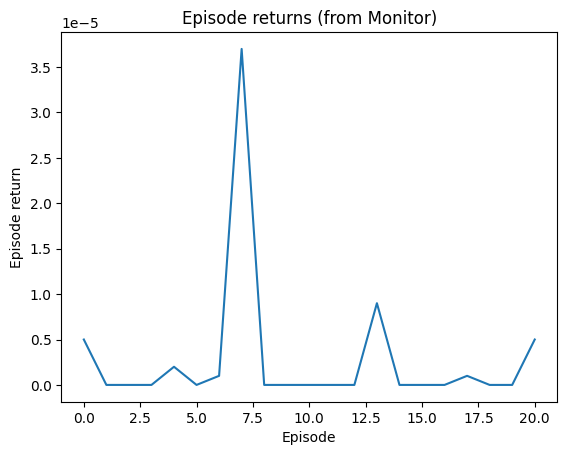

In [62]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.read_csv("monitor.csv", skiprows=1)  # Monitor adds a header line
plt.figure()
plt.plot(df["r"])
plt.xlabel("Episode")
plt.ylabel("Episode return")
plt.title("Episode returns (from Monitor)")
plt.show()

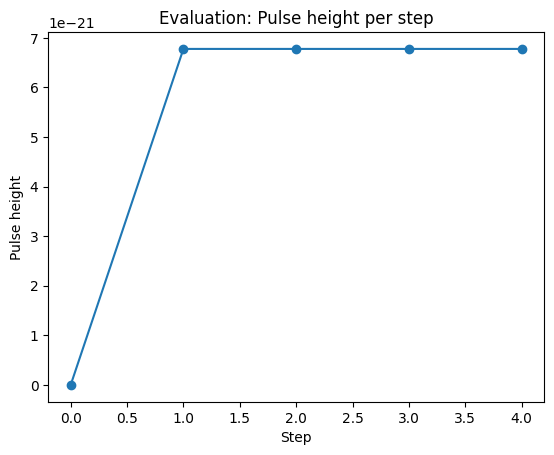

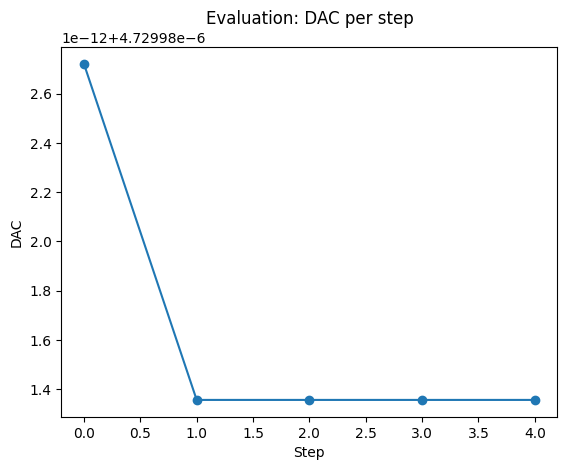

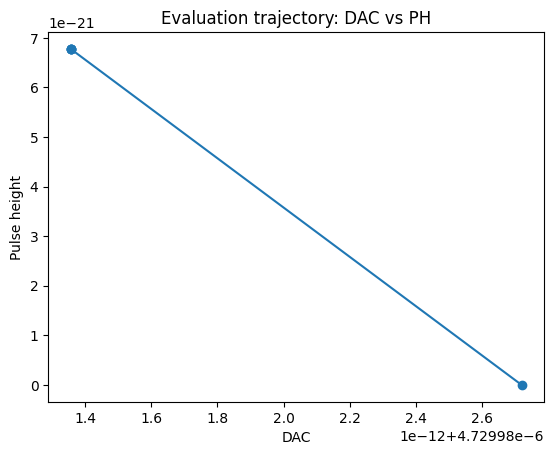

In [63]:
import matplotlib.pyplot as plt
dacs, phs, rewards = [], [], []

obs, _ = env.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, r, term, trunc, info = env.step(action)
    done = term or trunc
    dacs.append(obs[0]); phs.append(obs[1]); rewards.append(r)

# Plot PH over steps
plt.figure()
plt.plot(phs, marker="o")
plt.xlabel("Step")
plt.ylabel("Pulse height")
plt.title("Evaluation: Pulse height per step")
plt.show()

# Plot DAC over steps
plt.figure()
plt.plot(dacs, marker="o")
plt.xlabel("Step")
plt.ylabel("DAC")
plt.title("Evaluation: DAC per step")
plt.show()

# Optional: phase plot DAC vs PH
plt.figure()
plt.plot(dacs, phs, marker="o")
plt.xlabel("DAC")
plt.ylabel("Pulse height")
plt.title("Evaluation trajectory: DAC vs PH")
plt.show()

### (Bad) evaluation of the discovered policy

In [52]:
print("\n--- EVALUATION RUN ---")
obs, _ = env.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)  # greedy (mean) policy
    obs, reward, term, trunc, info = env.step(action)
    done = term or trunc
    print(f"step={info['step']}, DAC={obs[0]:.2e}, PH={obs[1]:.3e}, R={reward:.3e}")


--- EVALUATION RUN ---
step=1, DAC=4.40e-06, PH=0.000e+00, R=0.000e+00
step=2, DAC=4.40e-06, PH=0.000e+00, R=0.000e+00
step=3, DAC=4.40e-06, PH=0.000e+00, R=0.000e+00
step=4, DAC=4.40e-06, PH=0.000e+00, R=0.000e+00
step=5, DAC=4.40e-06, PH=0.000e+00, R=0.000e+00


In [54]:
# unwrap
real_env = env
while hasattr(real_env, "env"):
    real_env = real_env.env

sim = real_env.sim
dac = 4.62e-06
for _ in range(3):
    sim.set_heater_tp(tp_amplitude=real_env.tpa)   # <-- re-arm pulse
    sim.set_bias(bias_voltage=real_env.bias_v)
    sim.set_heater(dac)
    sim.solve()
    ph = float(np.max(sim.I_T) - np.min(sim.I_T))
    print("PH@4.62e-06 =", ph)

PH@4.62e-06 = 6.776263578034403e-21
PH@4.62e-06 = 6.776263578034403e-21
PH@4.62e-06 = 6.776263578034403e-21
